In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  data_set = scipy.io.loadmat('data.mat')
  train_set_X = data_set['X'].T
  train_set_Y = data_set['y'].T
  test_set_X = data_set['Xval'].T
  test_set_Y = data_set['yval'].T
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

Text(0.5, 1.0, 'Ground Positions')

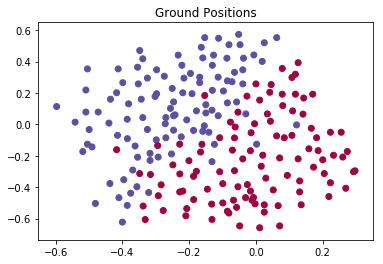

In [9]:
train_set_X,train_set_Y,test_set_X,test_set_Y=Load_Data()
plt.scatter(train_set_X[0,:],train_set_X[1,:],c=train_set_Y[0,:],cmap=plt.cm.Spectral)
plt.title('Ground Positions')

In [0]:
def Initialize_Parameters(layers_dims):
  
  parameters={}
  L = len(layers_dims)
  for l in range(1,L):
    W = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(1/layers_dims[l-1])*0.0001
    b = np.zeros((layers_dims[l],1))
    Y = np.random.randn(layers_dims[l],1)*np.sqrt(1/layers_dims[l-1])*0.0001
    B = np.zeros((layers_dims[l],1))
    
    parameters['W'+str(l)] = W 
    parameters['b'+str(l)] = b
    parameters['Y'+str(l)] = Y
    parameters['B'+str(l)] = B
  
  return parameters

In [0]:
def Initialize_Optimizer(parameters):
  
  v = {} 
  s = {}
  L = int(len(parameters)/4)
  
  for l in range(L):
    dW = np.zeros(parameters['W'+str(l+1)].shape)
    db = np.zeros(parameters['b'+str(l+1)].shape)
    dY = np.zeros(parameters['Y'+str(l+1)].shape)
    dB = np.zeros(parameters['B'+str(l+1)].shape)

    s['dW'+str(l+1)] = v['dW'+str(l+1)] = dW
    s['db'+str(l+1)] = v['db'+str(l+1)] = db
    s['dY'+str(l+1)] = v['dY'+str(l+1)] = dY
    s['dB'+str(l+1)] = v['dB'+str(l+1)] = dB
  
  return v,s

In [0]:
def sigmoid(Z):
  
  A = 1/(1+np.exp(-Z))
  return A

In [0]:
def relu(Z):
  
  A = np.maximum(Z,0.0001)
  return A

In [0]:
def softmax(Z):
  
  exp = np.exp(Z)
  expnorm = np.sum(exp,axis=0,keepdims=True)
  A = exp/expnorm
  assert(expnorm.shape == (1,exp.shape[1]))
  
  return A

In [0]:
def Compute_Z(A,W,b):
  
  Z = np.dot(W,A) + b
  return Z

In [0]:
def Forward_Propagation_Helper(A,W,b,Y,B,activation):
  
  m_train = A.shape[1]
  Z = Compute_Z(A,W,b)
  mu = np.sum(Z,axis=1,keepdims=True)/m_train
  Z_minus_mu = Z - mu
  sigma = np.sqrt(np.sum(np.square(Z_minus_mu),axis=1,keepdims=True)/m_train)
  ZNorm = Z_minus_mu/sigma
  Zcap = Y*ZNorm + B
  
  if(activation == 'relu'):
    A = relu(Zcap)
  elif(activation == 'sigmoid'):
    A = sigmoid(Zcap)
  elif(activation == 'softmax'):
    A = softmax(Zcap)
   
  return A,ZNorm,sigma

In [0]:
def Forward_Propagation(train_set_X,parameters,keep_prob):
  
  L = int(len(parameters)/4)
  A = train_set_X
  cache = {}
  
  for l in range(L):
    t = l+1
    cache['A'+str(l)] = A
    if(t < L):
      activation = 'relu'
    elif(parameters['W'+str(L)].shape[0] > 1):
      activation = 'softmax'
    else :
      activation = 'sigmoid'
    A,ZNorm,sigma = Forward_Propagation_Helper(A,parameters['W'+str(t)],parameters['b'+str(t)],parameters['Y'+str(t)],parameters['B'+str(t)],activation)
    if (t != L):
      P = np.random.randn(A.shape[0],A.shape[1])
      P = 1-np.ceil(P-keep_prob[l])
      A = A*P
      A = A/keep_prob[l]
      cache['P'+str(t)] = P
    cache['ZNorm'+str(t)] = ZNorm
    cache['sigma'+str(t)] = sigma
  cache['A'+str(L)] = A
  
  return cache,A

In [0]:
def compute_cost_sigmoid(Y,A,parameters,regu,lambd):
  
  m_train = Y.shape[1]
  cost = np.nansum(Y*np.log(A))+np.sum((1-Y)*np.log(1-A))
  cost = -cost
  
  if(regu):
    L = int(len(parameters)/4)
    sum = 0
    for l in range(L):
      W = parameters['W'+str(l+1)]
      sum = sum + np.sum(np.square(W))
    sum = sum * (lambd*0.5/m_train)
    cost = cost + sum
  
  return cost

In [0]:
def compute_cost_softmax(Y,A,parameters,regu,lambd):
  
  m_train = Y.shape[1]
  cost = np.sum(Y*np.log(A))
  cost = -cost
  
  if(regu):
    L = int(len(parameters)/4)
    sum = 0
    for l in range(L):
      W = parameters['W'+str(l+1)]
      sum = sum + np.sum(np.square(W))
    sum = sum * (lambd*0.5/m_train)
    cost = cost + sum
   
  return cost

In [0]:
def relu_backward(dA,A):
  
  dZ = dA * np.int32(A>0)
  return dZ

In [0]:
def sigmoid_backward(dA,A):
  
  dZ = A*(1-A) * dA
  return dZ

In [0]:
def Backward_Propagation_Helper(flag,dA,W,Y,A_prev,A_curr,ZNorm,sigma,activation,regu,lambd):
  
  if(flag):
    dZcap = dA
  else:
    if(activation == 'relu'):
      dZcap = relu_backward(dA,A_curr)
    elif(activation == 'sigmoid'):
      dZcap = sigmoid_backward(dA,A_curr)
  
  m_train = A_curr.shape[1]
  dZNorm = Y * dZcap
  dZ = dZNorm / sigma
  dW = np.dot(dZ,A_prev.T)/m_train
  if(regu):
    dW = dW + W*lambd/m_train
  db = np.sum(dZ,axis=1,keepdims=True)/m_train
  dY = np.sum(dZcap * ZNorm,axis=1,keepdims=True)/m_train
  dB = np.sum(dZcap,axis=1,keepdims=True)/m_train
  dA = np.dot(W.T,dZ)
  
  assert(W.shape == dW.shape)
  
  return dA,dW,db,dY,dB

In [0]:
def Backward_Propagation(train_set_Y,A,parameters,cache,keep_prob,regu,lambd):
  
  grads = {}
  L = int(len(parameters)/4)
  activation = 'relu'
  
  dA = A - train_set_Y
  for l in reversed(range(L)):
    if(l == L-1):
      flag = True
    else:
      flag = False
      dA = dA * cache['P'+str(l+1)]
      dA = dA/keep_prob[l]

    dA,dW,db,dY,dB = Backward_Propagation_Helper(flag,dA,parameters['W'+str(l+1)],parameters['Y'+str(l+1)],cache['A'+str(l)],cache['A'+str(l+1)],cache['ZNorm'+str(l+1)],cache['sigma'+str(l+1)],activation,regu,lambd)
    grads['dW'+str(l+1)] = dW
    grads['db'+str(l+1)] = db
    grads['dY'+str(l+1)] = dY
    grads['dB'+str(l+1)] = dB
    
  return grads

In [0]:
def Update_Parameters(grads,parameters,learning_rate,v,s,beta1,beta2,t,epsilon=1e-8):

  L = int(len(parameters)/4)
  
  for l in range(L):
    v['dW'+str(l+1)] = beta1*v['dW'+str(l+1)] + (1-beta1)*grads['dW'+str(l+1)]
    vdW_corr = v['dW'+str(l+1)]/(1-(beta1**t))
    v['db'+str(l+1)] = beta1*v['db'+str(l+1)] + (1-beta1)*grads['db'+str(l+1)] 
    vdb_corr = v['db'+str(l+1)]/(1-(beta1**t))
    v['dY'+str(l+1)] = beta1*v['dY'+str(l+1)] + (1-beta1)*grads['dY'+str(l+1)]
    vdY_corr = v['dY'+str(l+1)]/(1-(beta1**t))
    v['dB'+str(l+1)] = beta1*v['dB'+str(l+1)] + (1-beta1)*grads['dB'+str(l+1)]
    vdB_corr = v['dB'+str(l+1)]/(1-(beta1**t))

    s['dW'+str(l+1)] = beta2*s['dW'+str(l+1)] + (1-beta2)*(grads['dW'+str(l+1)]**2)
    sdW_corr = s['dW'+str(l+1)]/(1-(beta2**t))
    s['db'+str(l+1)] = beta2*s['db'+str(l+1)] + (1-beta2)*(grads['db'+str(l+1)]**2)
    sdb_corr = s['db'+str(l+1)]/(1-(beta2**t))
    s['dY'+str(l+1)] = beta2*s['dY'+str(l+1)] + (1-beta2)*(grads['dY'+str(l+1)]**2)
    sdY_corr = s['dY'+str(l+1)]/(1-(beta2**t))
    s['dB'+str(l+1)] = beta2*s['dB'+str(l+1)] + (1-beta2)*(grads['dB'+str(l+1)]**2)
    sdB_corr = s['dB'+str(l+1)]/(1-(beta2**t))

    #print(t,l,"vdw",vdW_corr)
    parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate*vdW_corr/(np.sqrt(sdW_corr)+epsilon)
    parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*vdb_corr/(np.sqrt(sdb_corr)+epsilon)
    parameters['Y'+str(l+1)] = parameters['Y'+str(l+1)] - learning_rate*vdY_corr/(np.sqrt(sdY_corr)+epsilon)
    parameters['B'+str(l+1)] = parameters['B'+str(l+1)] - learning_rate*vdB_corr/(np.sqrt(sdB_corr)+epsilon)
  
  return parameters,v,s

In [0]:
def Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size):
  
  m_train = train_set_X.shape[1]
  perm = list(np.random.permutation(train_set_X.shape[1]))
  train_set_X = train_set_X[:,perm]
  train_set_Y = train_set_Y[:,perm]
  
  n = int(m_train/mini_batch_size)
  minibatches = []
  
  for i in range(n):
    X = train_set_X[:,i*mini_batch_size:(i+1)*mini_batch_size]
    Y = train_set_Y[:,i*mini_batch_size:(i+1)*mini_batch_size]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  if(m_train % mini_batch_size != 0):
    X = train_set_X[:,n*mini_batch_size:m_train]
    Y = train_set_Y[:,n*mini_batch_size:m_train]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  return minibatches

In [0]:
def dictionary_to_vector(parameters):
  
  res = np.array([])
  
  for items in parameters:
    items = parameters[items]
    shape = items.shape
    items = np.reshape(items,shape[0]*shape[1])
    res = np.append(res,items)
    
  return res

In [0]:
def vector_to_dictionary(J,param):
  
  parameters = {}
  j = 0
  
  for key,value in param.items():
    shape = value.shape
    size = shape[0]*shape[1]
    temp = J[j:j+size]
    j = j+size
    temp = np.reshape(temp,shape)
    parameters[key] = temp
 
  return parameters

In [0]:
def Gradient_Checking(grads,parameters,X,Y,keep_prob,regu,lambd,epsilon=1e-7):
 
  J = dictionary_to_vector(parameters)
  G_out = dictionary_to_vector(grads)
  m = len(J)
  J_out = np.zeros(m)
  L = int(len(parameters)/4)
  
  for i in range(m):
    J_plus = np.copy(J)
    J_plus[i] = J_plus[i]+epsilon
    param = vector_to_dictionary(J_plus,parameters)
    cache,A = Forward_Propagation(X,param,keep_prob)
    
    if(parameters['W'+str(L)].shape[0] > 1):
      cost1 = compute_cost_softmax(Y,A,param,regu,lambd)
    else :
      cost1 = compute_cost_sigmoid(Y,A,param,regu,lambd)
    
    J_minus = np.copy(J)
    J_minus[i] = J_minus[i]-epsilon
    param = vector_to_dictionary(J_minus,parameters)
    cache,A = Forward_Propagation(X,param,keep_prob)
    
    if(parameters['W'+str(L)].shape[0] > 1):
      cost2 = compute_cost_softmax(Y,A,param,regu,lambd)
    else :
      cost2 = compute_cost_sigmoid(Y,A,param,regu,lambd)
    
    #print(J,J_plus,J_minus)
    J_out[i] = (cost1-cost2)/(2*epsilon)
 
  dis = np.linalg.norm(J_out-G_out)/(np.linalg.norm(J_out)+np.linalg.norm(G_out))
  
  return dis

In [0]:
def Predict(X,parameters,keep_prob):
  
  cache,A = Forward_Propagation(X,parameters,keep_prob)
  L = int(len(parameters)/4)
  if(parameters['W'+str(L)].shape[0] == 1):
    A = np.abs(np.ceil(A-0.5))
    A = A.astype('int32')
  else:
    A = np.argmax(A,axis=0)
    A = np.eye(2)[A][0].T
   
  return A

In [0]:
def Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,keep_prob,mini_batch_size):
  
  beta1 = 0.8
  beta2 = 0.9
  beta3 = 0.99
  lambd = 0.7
  regu = False
  
  L = len(layers_dims)
  if(layers_dims[L-1] > 1):
    train_set_Y = np.eye(2)[train_set_Y][0].T
    test_set_Y = np.eye(2)[test_set_Y][0].T
    
  total_cost = []
  parameters = Initialize_Parameters(layers_dims)
  v,s = Initialize_Optimizer(parameters)
  L = int(len(parameters)/4)
  
  for i in range(epochs):
    minibatches = Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size)
    for minibatch in minibatches:
      (X,Y) = minibatch
      cache,A = Forward_Propagation(X,parameters,keep_prob)
      
      if(parameters['W'+str(L)].shape[0] > 1):
        cost = compute_cost_softmax(Y,A,parameters,regu,lambd)
      else :
        cost = compute_cost_sigmoid(Y,A,parameters,regu,lambd)
      
      grads = Backward_Propagation(Y,A,parameters,cache,keep_prob,regu,lambd)
      
      if (i % 10000 == 0):
        flag=Gradient_Checking(grads,parameters,X,Y,keep_prob=[1,1,1],regu=regu,lambd=lambd)
        print("Result of Gradient Checking : "+str(flag))
        
      parameters,v,s = Update_Parameters(grads,parameters,learning_rate,v,s,beta2,beta3,i+1)
      
    if(i % 1000 == 0):
      print('Cost after '+str(i)+'th Iteration : '+str(cost))
      
    if(i % 500 == 0):
        total_cost.append(cost)
     
  A_train = Predict(train_set_X,parameters,keep_prob)
  A_test = Predict(test_set_X,parameters,keep_prob)
  
  if(parameters['W'+str(L)].shape[0] == 1):
    train_acc = 100-np.mean(np.abs(train_set_Y-A_train))*100
    test_acc = 100-np.mean(np.abs(test_set_Y-A_test))*100
    
  elif(parameters['W'+str(L)].shape[0] > 1):
    train_temp = np.equal(np.argmax(A_train,axis=0),np.argmax(train_set_Y,axis=0))
    train_acc = np.mean(train_temp.astype('int32'))*100
    test_temp = np.equal(np.argmax(A_test,axis=0),np.argmax(test_set_Y,axis=0))
    test_acc = np.mean(test_temp.astype('int32'))*100
  
  print("Training Set Accuracy : "+str(train_acc))
  print("Test Set Accuracy : "+str(test_acc))
  
  plt.plot(total_cost)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title("Learning_Rate : "+str(learning_rate))
  plt.show()  
  
  return parameters

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Load_Data()
  learning_rate = 0.2
  epochs = 30000
  mini_batch_size = 211
  layers_dims = [train_set_X.shape[0]]
  layers_dims.extend([50,20,1])
  keep_prob = [1,1,1]
  parameters = Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,keep_prob,mini_batch_size)
  
  for key,value in parameters.items():
    print(key,value)

Result of Gradient Checking : 0.9997966795798491
Cost after 0th Iteration : 146.25406628024245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after 1000th Iteration : 55.00508209617036
Cost after 2000th Iteration : 51.12932956848708
Cost after 3000th Iteration : 52.07187094024236
Cost after 4000th Iteration : 52.32165879318576
Cost after 5000th Iteration : 50.870319341447406
Cost after 6000th Iteration : 53.8649833585128
Cost after 7000th Iteration : 55.5374606127413
Cost after 8000th Iteration : 49.38274071628696
Cost after 9000th Iteration : 51.91454432519379
Result of Gradient Checking : 0.9999999999926176
Cost after 10000th Iteration : 48.474313873792326
Cost after 11000th Iteration : 48.51741273102935
Cost after 12000th Iteration : 53.23568539302381
Cost after 13000th Iteration : 55.81380307454934
Cost after 14000th Iteration : 49.31711611126873
Cost after 15000th Iteration : 50.224834716408864
Cost after 16000th Iteration : 48.3524403565462
Cost after 17000th Iteration : 48.575010541111624
Cost after 18000th Iteration : 50.526366514815486
Cost after 19000th Iteration : 49.97451981185538
Result of Gradient Checking

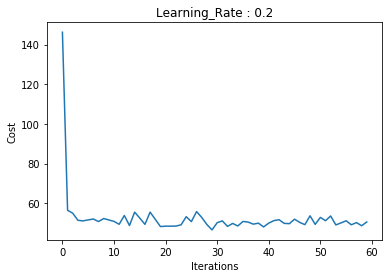

W1 [[ 1879.95812823  -985.18968046]
 [ 1740.8636465   -884.15290073]
 [-1836.3294858   1050.48130841]
 [ 1582.55711533 -1340.23211438]
 [ 1734.57496587  -863.4699304 ]
 [ 1759.53731337  -906.56612268]
 [ 1885.02543188  -996.14649292]
 [ 1894.3664838  -1015.77204514]
 [-1758.74936954   874.50570766]
 [  865.31555309 -1750.6642716 ]
 [-1740.23349344  1138.74105193]
 [ 1898.91340712  -994.41128431]
 [-1870.04576156   991.87122491]
 [-1721.38878516   857.99379679]
 [ 1703.15839506  -904.29845933]
 [ 1865.78708996 -1031.42935704]
 [ 1848.32296153 -1018.92042772]
 [-1884.79298691  1026.85281371]
 [-1680.48288319   863.21081249]
 [-1720.07365497   868.86062169]
 [ 1809.55593523 -1079.0042623 ]
 [ -730.76039334  1780.25333804]
 [ 1838.78478458 -1051.80283255]
 [ 1710.80471376  -855.20649179]
 [-1731.75817907   850.31137849]
 [ -792.96148201  1780.63898085]
 [-1699.17783282   866.02938083]
 [ 1750.7259428   -893.06581781]
 [ 1915.62714245  -987.99871986]
 [-1748.17647227   899.29082512]
 [ 1751

In [102]:
Caller_Function()